<div style="background-color:white; text-align:center; padding:10px; color:black; margin-left:0px; border-radius: 10px; font-family:Trebuchet MS; font-size:45px">
<strong>Mejores prácticas en Spark</strong>
</div>

<div style="background-color:lightblue; text-align:center; padding:1px; color:black; margin-left:0px; border-radius: 5px; font-family:Trebuchet MS; font-size:35px">
Haz esto!
</div>

<table class="table table-bordered table-hover">
  <thead>
    <tr>
      <th scope="col">Autor</th>
      <th scope="col">Fecha</th>
      <th scope="col">Lugar</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Marcos</td>
      <td>Junio de 2020</td>
      <td>Ciudad de México, México</td>
    </tr>
  </tbody>
</table>

# Cargamos nuestro documento que esta en formato CSV

In [1]:
import pyspark
sc = pyspark.SparkContext('local[*]')
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [2]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
sqlContext = SQLContext(sc)

Supongamos que tenemos una base de datos de una institución financiera y en ella hay información de tipo numéricas (por ejemplo: saldos, ingresos, etc.) y categóricas (por ejemplo: tipo de saldo, tipo de ingreso, etc.) y esta se encuentra en formato _CSV_.

Ejemplo de archivo CSV:

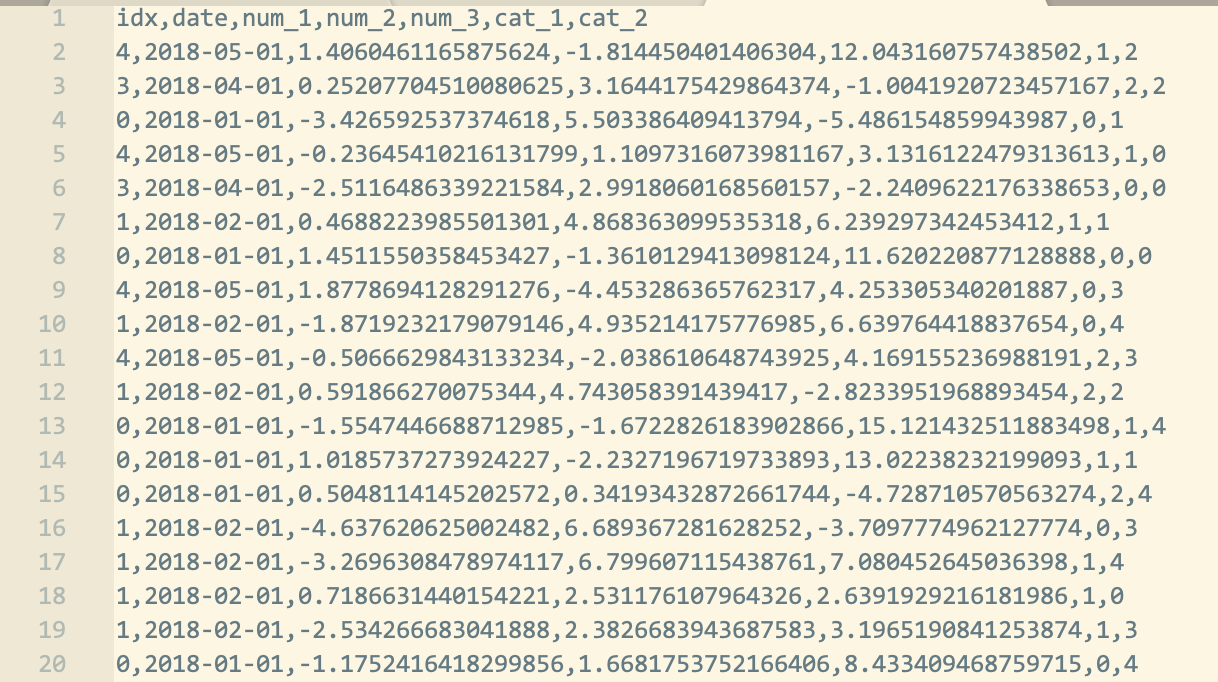

In [3]:
from IPython.display import Image
Image(filename='../images/csv_file.png', width=550) 

Hay muchas formas de cargar información a Spark, aquí veremos una en donde el formato de origen es un CSV y conocemos el tipo de datos que tiene la base.

Por lo tanto, crearemos el esquema de la tabla para usarlo en la carga:

In [4]:
schema = StructType([StructField('idx', StringType(), True),
                     StructField('date', DateType(), True),
                     StructField('num_1', DoubleType(), True),
                     StructField('num_2', DoubleType(), True),
                     StructField('num_3', DoubleType(), True),
                     StructField('cat_1', IntegerType(), True),
                     StructField('cat_2', IntegerType(), True)
                    ])

El objetivo del esquema es:

- por un lado, garantizar que los datos que estamos cargando tengan el formato correcto;
- y por el otro, cargar más rápido la base de datos.

In [5]:
df = sqlContext.read.csv('../data/tmp_evol.csv', sep=',', header=True, schema=schema)

In [6]:
df.printSchema()

root
 |-- idx: string (nullable = true)
 |-- date: date (nullable = true)
 |-- num_1: double (nullable = true)
 |-- num_2: double (nullable = true)
 |-- num_3: double (nullable = true)
 |-- cat_1: integer (nullable = true)
 |-- cat_2: integer (nullable = true)



In [7]:
print('Filas: {:,}\tColumnas: {:,}'.format(df.count(),len(df.columns)))

Filas: 10,000	Columnas: 7


In [8]:
df.show(5)

+---+----------+--------------------+------------------+-------------------+-----+-----+
|idx|      date|               num_1|             num_2|              num_3|cat_1|cat_2|
+---+----------+--------------------+------------------+-------------------+-----+-----+
|  4|2018-05-01|  1.4060461165875624|-1.814450401406304| 12.043160757438502|    1|    2|
|  3|2018-04-01| 0.25207704510080625|3.1644175429864374|-1.0041920723457167|    2|    2|
|  0|2018-01-01|  -3.426592537374618| 5.503386409413794| -5.486154859943987|    0|    1|
|  4|2018-05-01|-0.23645410216131799|1.1097316073981167| 3.1316122479313613|    1|    0|
|  3|2018-04-01| -2.5116486339221584|2.9918060168560157|-2.2409622176338653|    0|    0|
+---+----------+--------------------+------------------+-------------------+-----+-----+
only showing top 5 rows



# Algunas cosas que debemos hacer

In [9]:
from pyspark.sql import functions as F

### Visualizar la información

In [10]:
df.select('*').limit(5).toPandas()

,idx,date,num_1,num_2,num_3,cat_1,cat_2
0,4,2018-05-01,1.406046,-1.814450,12.043161,1,2
1,3,2018-04-01,0.252077,3.164418,-1.004192,2,2
2,0,2018-01-01,-3.426593,5.503386,-5.486155,0,1
3,4,2018-05-01,-0.236454,1.109732,3.131612,1,0
4,3,2018-04-01,-2.511649,2.991806,-2.240962,0,0


In [11]:
df.limit(5).toPandas()

,idx,date,num_1,num_2,num_3,cat_1,cat_2
0,4,2018-05-01,1.406046,-1.814450,12.043161,1,2
1,3,2018-04-01,0.252077,3.164418,-1.004192,2,2
2,0,2018-01-01,-3.426593,5.503386,-5.486155,0,1
3,4,2018-05-01,-0.236454,1.109732,3.131612,1,0
4,3,2018-04-01,-2.511649,2.991806,-2.240962,0,0


In [12]:
df.show(5)

+---+----------+--------------------+------------------+-------------------+-----+-----+
|idx|      date|               num_1|             num_2|              num_3|cat_1|cat_2|
+---+----------+--------------------+------------------+-------------------+-----+-----+
|  4|2018-05-01|  1.4060461165875624|-1.814450401406304| 12.043160757438502|    1|    2|
|  3|2018-04-01| 0.25207704510080625|3.1644175429864374|-1.0041920723457167|    2|    2|
|  0|2018-01-01|  -3.426592537374618| 5.503386409413794| -5.486154859943987|    0|    1|
|  4|2018-05-01|-0.23645410216131799|1.1097316073981167| 3.1316122479313613|    1|    0|
|  3|2018-04-01| -2.5116486339221584|2.9918060168560157|-2.2409622176338653|    0|    0|
+---+----------+--------------------+------------------+-------------------+-----+-----+
only showing top 5 rows



### Crear columnas y borrar existentes

Hay que crear las columnas de la forma correcta

In [13]:
malo = df.withColumn('tmp', F.col('num_1')-F.lit(100))

In [14]:
malo.show(5)

+---+----------+--------------------+------------------+-------------------+-----+-----+-------------------+
|idx|      date|               num_1|             num_2|              num_3|cat_1|cat_2|                tmp|
+---+----------+--------------------+------------------+-------------------+-----+-----+-------------------+
|  4|2018-05-01|  1.4060461165875624|-1.814450401406304| 12.043160757438502|    1|    2| -98.59395388341244|
|  3|2018-04-01| 0.25207704510080625|3.1644175429864374|-1.0041920723457167|    2|    2|  -99.7479229548992|
|  0|2018-01-01|  -3.426592537374618| 5.503386409413794| -5.486154859943987|    0|    1|-103.42659253737462|
|  4|2018-05-01|-0.23645410216131799|1.1097316073981167| 3.1316122479313613|    1|    0|-100.23645410216132|
|  3|2018-04-01| -2.5116486339221584|2.9918060168560157|-2.2409622176338653|    0|    0|-102.51164863392216|
+---+----------+--------------------+------------------+-------------------+-----+-----+-------------------+
only showing top 5 

In [15]:
malo = malo.drop('num_1')

In [16]:
malo.show(5)

+---+----------+------------------+-------------------+-----+-----+-------------------+
|idx|      date|             num_2|              num_3|cat_1|cat_2|                tmp|
+---+----------+------------------+-------------------+-----+-----+-------------------+
|  4|2018-05-01|-1.814450401406304| 12.043160757438502|    1|    2| -98.59395388341244|
|  3|2018-04-01|3.1644175429864374|-1.0041920723457167|    2|    2|  -99.7479229548992|
|  0|2018-01-01| 5.503386409413794| -5.486154859943987|    0|    1|-103.42659253737462|
|  4|2018-05-01|1.1097316073981167| 3.1316122479313613|    1|    0|-100.23645410216132|
|  3|2018-04-01|2.9918060168560157|-2.2409622176338653|    0|    0|-102.51164863392216|
+---+----------+------------------+-------------------+-----+-----+-------------------+
only showing top 5 rows



Siempre será importante ahorrar pasos

In [17]:
columnas = [x for x in df.columns if x not in 'num_1']

In [18]:
columnas

['idx', 'date', 'num_2', 'num_3', 'cat_1', 'cat_2']

In [19]:
bueno = df.select(*columnas,
                  (F.col('num_1')-F.lit(100)).alias('tmp'))

In [20]:
bueno.show(5)

+---+----------+------------------+-------------------+-----+-----+-------------------+
|idx|      date|             num_2|              num_3|cat_1|cat_2|                tmp|
+---+----------+------------------+-------------------+-----+-----+-------------------+
|  4|2018-05-01|-1.814450401406304| 12.043160757438502|    1|    2| -98.59395388341244|
|  3|2018-04-01|3.1644175429864374|-1.0041920723457167|    2|    2|  -99.7479229548992|
|  0|2018-01-01| 5.503386409413794| -5.486154859943987|    0|    1|-103.42659253737462|
|  4|2018-05-01|1.1097316073981167| 3.1316122479313613|    1|    0|-100.23645410216132|
|  3|2018-04-01|2.9918060168560157|-2.2409622176338653|    0|    0|-102.51164863392216|
+---+----------+------------------+-------------------+-----+-----+-------------------+
only showing top 5 rows



<div class="alert alert-success alert-dismissable" role="alert">
En un solo paso creamos una nueva columna y eliminamos una existente.
</div>

Incluso si queremos eliminar mas de una columna, lo mejor es hacerlo de la siguiente forma:

In [21]:
columnas = [x for x in df.columns if x not in ['num_1','num_2','num_3']]

In [22]:
columnas

['idx', 'date', 'cat_1', 'cat_2']

### Trabajar sobre columnas actualizadas en el mismo paso

In [23]:
tmp = df.select('*',F.lit(1).alias('tmp'))

In [24]:
columnas = [x for x in tmp.columns if x not in 'tmp']

In [25]:
tmp = tmp.select(*columnas,
                 (F.col('tmp')*10).alias('tmp'),
                 (F.col('tmp')).alias('old_tmp')
                )

In [26]:
tmp.show(5)

+---+----------+--------------------+------------------+-------------------+-----+-----+---+-------+
|idx|      date|               num_1|             num_2|              num_3|cat_1|cat_2|tmp|old_tmp|
+---+----------+--------------------+------------------+-------------------+-----+-----+---+-------+
|  4|2018-05-01|  1.4060461165875624|-1.814450401406304| 12.043160757438502|    1|    2| 10|      1|
|  3|2018-04-01| 0.25207704510080625|3.1644175429864374|-1.0041920723457167|    2|    2| 10|      1|
|  0|2018-01-01|  -3.426592537374618| 5.503386409413794| -5.486154859943987|    0|    1| 10|      1|
|  4|2018-05-01|-0.23645410216131799|1.1097316073981167| 3.1316122479313613|    1|    0| 10|      1|
|  3|2018-04-01| -2.5116486339221584|2.9918060168560157|-2.2409622176338653|    0|    0| 10|      1|
+---+----------+--------------------+------------------+-------------------+-----+-----+---+-------+
only showing top 5 rows



<div class="alert alert-danger" role="alert">
Como se puede ver, no estamos trabajando sobre la columna <code>tmp</code> actualizada
</div>

Lo que se debe hacer es lo siguiente:

In [27]:
tmp = df.select('*',F.lit(1).alias('tmp'))

In [28]:
lista_columnas = [x for x in tmp.columns if x not in 'tmp']

In [29]:
tmp = tmp.select(*lista_columnas,
                 (F.col('tmp')*10).alias('tmp'))

tmp = tmp.select('*',
                 (F.col('tmp')).alias('tmp_new'))

In [30]:
tmp.show(5)

+---+----------+--------------------+------------------+-------------------+-----+-----+---+-------+
|idx|      date|               num_1|             num_2|              num_3|cat_1|cat_2|tmp|tmp_new|
+---+----------+--------------------+------------------+-------------------+-----+-----+---+-------+
|  4|2018-05-01|  1.4060461165875624|-1.814450401406304| 12.043160757438502|    1|    2| 10|     10|
|  3|2018-04-01| 0.25207704510080625|3.1644175429864374|-1.0041920723457167|    2|    2| 10|     10|
|  0|2018-01-01|  -3.426592537374618| 5.503386409413794| -5.486154859943987|    0|    1| 10|     10|
|  4|2018-05-01|-0.23645410216131799|1.1097316073981167| 3.1316122479313613|    1|    0| 10|     10|
|  3|2018-04-01| -2.5116486339221584|2.9918060168560157|-2.2409622176338653|    0|    0| 10|     10|
+---+----------+--------------------+------------------+-------------------+-----+-----+---+-------+
only showing top 5 rows



### Muchas gracias